
# Part C – Reinforcement Learning Model Selector

This notebook:
- Loads ML and DL prediction results.
- Builds RL state vectors containing:
  - ML probability
  - DL probability
  - Confidence difference
  - Review length
- Defines actions:
  - 0 = use ML model
  - 1 = use DL model
- Defines a reward function (e.g., +10 correct, –5 incorrect).
- Trains a Q-learning agent for 800–1500 episodes.
- Plots reward over episodes.
- Compares accuracy of ML-only, DL-only, and RL-selected predictions.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

ml_results_path = PROCESSED_DIR / "ml_results.csv"
dl_results_path = PROCESSED_DIR / "dl_results.csv"

print("ML results:", ml_results_path)
print("DL results:", dl_results_path)


ML results: ..\data\processed\ml_results.csv
DL results: ..\data\processed\dl_results.csv



## 1. Load ML and DL Results and Merge


In [2]:

ml_df = pd.read_csv(ml_results_path)
dl_df = pd.read_csv(dl_results_path)

# Assumption: both files contain the same rows in the same order.
# If not, you may need to merge on an index or a unique ID.

assert len(ml_df) == len(dl_df), "ML and DL results must have same length"

merged = pd.DataFrame({
    "y_true": ml_df["y_true"],
    "p_ml": ml_df["p_ml"],
    "p_dl": dl_df["p_dl"],
    "review": ml_df["review"],
    "clean_review": ml_df.get("clean_review", ml_df["review"])
})

# Base accuracies for comparison
y_true = merged["y_true"].values
y_pred_ml = (merged["p_ml"].values >= 0.5).astype(int)
y_pred_dl = (merged["p_dl"].values >= 0.5).astype(int)

acc_ml = (y_pred_ml == y_true).mean()
acc_dl = (y_pred_dl == y_true).mean()

print(f"ML-only accuracy: {acc_ml:.4f}")
print(f"DL-only accuracy: {acc_dl:.4f}")


ML-only accuracy: 0.8925
DL-only accuracy: 0.8537



## 2. Construct RL State Vectors

State components:
- ML probability (p_ml)
- DL probability (p_dl)
- Confidence difference = |p_ml - p_dl|
- Review length (in tokens)


In [4]:

def compute_review_length(text):
    return len(str(text).split())

merged["review_length"] = merged["clean_review"].apply(compute_review_length)
merged["conf_diff"] = (merged["p_ml"] - merged["p_dl"]).abs()

# Normalize features (simple min-max)
for col in ["p_ml", "p_dl", "conf_diff", "review_length"]:
    col_min = merged[col].min()
    col_max = merged[col].max()
    merged[col + "_norm"] = (merged[col] - col_min) / (col_max - col_min + 1e-8)

state_cols = ["p_ml_norm", "p_dl_norm", "conf_diff_norm", "review_length_norm"]
state_matrix = merged[state_cols].values



## 3. Discretize States for Tabular Q-learning

Simple approach: bin each feature into a fixed number of buckets and
map binned states to Q-table indices.


In [5]:

NUM_BINS = 10

def discretize_feature(values, num_bins=NUM_BINS):
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    return np.digitize(values, bins) - 1  # values in [0, num_bins-1]

disc_states = np.zeros_like(state_matrix, dtype=int)
for i in range(state_matrix.shape[1]):
    disc_states[:, i] = discretize_feature(state_matrix[:, i])

def state_to_index(state_vector):
    """Map a 4D discrete state (each in [0, NUM_BINS-1]) to a single index."""
    b = NUM_BINS
    s0, s1, s2, s3 = state_vector
    return s0 + b * (s1 + b * (s2 + b * s3))

num_states = NUM_BINS ** state_matrix.shape[1]
num_actions = 2  # 0=use ML, 1=use DL

print("Number of discrete states:", num_states)
print("Number of actions:", num_actions)


Number of discrete states: 10000
Number of actions: 2



## 4. Define Reward Function

Example:
- +10 if chosen model prediction is correct
- -5 if incorrect


In [6]:

def compute_reward(action, index):
    """
    action: 0=use ML, 1=use DL
    index: index of sample in merged DataFrame
    """
    true_label = y_true[index]
    if action == 0:
        pred = y_pred_ml[index]
    else:
        pred = y_pred_dl[index]

    if pred == true_label:
        return 10.0
    else:
        return -5.0



## 5. Q-learning Loop

- Initialize Q-table.
- For each episode (800–1500):
  - Loop through all samples in the dataset.
  - For each state, choose an action (epsilon-greedy).
  - Observe reward and update Q-table.

At the end, derive a policy and compute RL-selected accuracy.


In [7]:

num_states = NUM_BINS ** len(state_cols)
num_actions = 2

Q = np.zeros((num_states, num_actions), dtype=float)

# Hyperparameters
alpha = 0.1      # learning rate
gamma = 0.9      # discount factor
epsilon_start = 1.0
epsilon_end = 0.05
num_episodes = 1000  # adjust to 800–1500 per assignment spec

rewards_per_episode = []

n_samples = len(merged)
indices = np.arange(n_samples)

for episode in range(num_episodes):
    # Epsilon decay
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * (1 - episode / max(1, num_episodes - 1))

    total_reward = 0.0

    # Shuffle order each episode
    np.random.shuffle(indices)

    for idx in indices:
        discrete_state = disc_states[idx]
        s = state_to_index(discrete_state)

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            a = np.random.randint(num_actions)
        else:
            a = np.argmax(Q[s])

        r = compute_reward(a, idx)
        total_reward += r

        # Tabular Q-learning update (no next-state because each step is independent)
        best_next = np.max(Q[s])
        Q[s, a] = Q[s, a] + alpha * (r + gamma * best_next - Q[s, a])

    rewards_per_episode.append(total_reward)

    if (episode + 1) % 50 == 0:
        print(f"Episode {episode+1}/{num_episodes}, total reward = {total_reward:.2f}, epsilon = {epsilon:.3f}")


Episode 50/1000, total reward = 101075.00, epsilon = 0.953
Episode 100/1000, total reward = 102005.00, epsilon = 0.906
Episode 150/1000, total reward = 101465.00, epsilon = 0.858
Episode 200/1000, total reward = 101510.00, epsilon = 0.811
Episode 250/1000, total reward = 102650.00, epsilon = 0.763
Episode 300/1000, total reward = 102440.00, epsilon = 0.716
Episode 350/1000, total reward = 102860.00, epsilon = 0.668
Episode 400/1000, total reward = 103895.00, epsilon = 0.621
Episode 450/1000, total reward = 103520.00, epsilon = 0.573
Episode 500/1000, total reward = 103940.00, epsilon = 0.525
Episode 550/1000, total reward = 103850.00, epsilon = 0.478
Episode 600/1000, total reward = 104345.00, epsilon = 0.430
Episode 650/1000, total reward = 104525.00, epsilon = 0.383
Episode 700/1000, total reward = 104750.00, epsilon = 0.335
Episode 750/1000, total reward = 104375.00, epsilon = 0.288
Episode 800/1000, total reward = 105305.00, epsilon = 0.240
Episode 850/1000, total reward = 105245.0


## 6. Plot Reward Curve


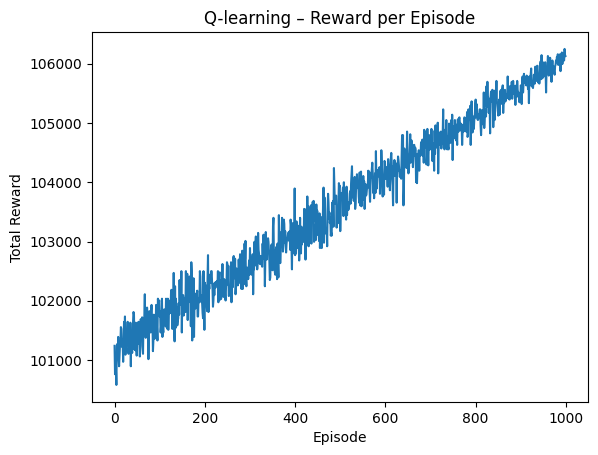

In [8]:

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning – Reward per Episode")
plt.show()



## 7. Evaluate RL Policy Accuracy

Derive the greedy policy from the learned Q-table and compute RL-selected accuracy.


In [9]:

# Derive greedy actions from Q-table
chosen_actions = []
rl_preds = []

for idx in range(n_samples):
    s = state_to_index(disc_states[idx])
    a_star = np.argmax(Q[s])
    chosen_actions.append(a_star)

    if a_star == 0:
        rl_preds.append(y_pred_ml[idx])
    else:
        rl_preds.append(y_pred_dl[idx])

rl_preds = np.array(rl_preds)
rl_acc = (rl_preds == y_true).mean()

print(f"ML-only accuracy: {acc_ml:.4f}")
print(f"DL-only accuracy: {acc_dl:.4f}")
print(f"RL-selected accuracy: {rl_acc:.4f}")


ML-only accuracy: 0.8925
DL-only accuracy: 0.8537
RL-selected accuracy: 0.9010



## 8. Inspect Learned Q-table (Optional)

You can inspect portions of the Q-table or save it to disk if needed.


In [10]:

# Save Q-table
q_table_path = PROCESSED_DIR / "q_table.npy"
np.save(q_table_path, Q)
print("Saved Q-table to:", q_table_path)

Q.shape


Saved Q-table to: ..\data\processed\q_table.npy


(10000, 2)